In [1]:
import cheetah
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
df = pd.read_csv("../electron_tt43.out", delim_whitespace=True, skiprows=45)

# Shift column names to the left
df.columns = df.columns[1:].tolist() + [""]
# Remove first row
df = df.iloc[1:]
# Drop last column
df = df.iloc[:, :-1]
# Convert all columns except for NAME and KEYWORD to float
df[df.columns[2:]] = df[df.columns[2:]].astype(float)

df

,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
1,TT43$START,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,BEGI.1000,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,DRIFT_0,DRIFT,0.179170,0.179170,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
4,BPM.430028,MONITOR,0.179170,0.000000,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
5,DRIFT_1,DRIFT,0.248570,0.069400,0.000984,0.000984,5.012357,5.012357,0.000000,0.000000,...,0.000000,-0.049714,-0.049714,0.0,0.0,0.0,0.007906,0.007906,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,IRIS2,INSTRUMENT,25.692571,0.000000,0.009802,0.010878,497.773560,494.605213,-0.005214,-0.000397,...,-0.056194,-44.983456,-43.909992,0.0,0.0,0.0,1.133650,2.080197,0.0,0.0
100,DRIFT_40,DRIFT,26.192571,0.500000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
101,PLASMA.S,INSTRUMENT,26.192571,0.000000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
102,DRIFT_41,DRIFT,30.000000,3.807429,0.013617,0.015086,960.761021,945.248720,-0.006923,-0.000397,...,-0.056194,-62.502344,-60.710072,0.0,0.0,0.0,1.134642,2.081200,0.0,0.0


In [3]:
df.columns


Index(['NAME', 'KEYWORD', 'S', 'L', 'SIGMA_X', 'SIGMA_Y', 'BETX', 'BETY', 'DX',
       'DPX', 'DY', 'DPY', 'ALFX', 'ALFY', 'X', 'Y', 'K1L', 'MUX', 'MUY',
       'ENV_X', 'ENV_Y'],
      dtype='object')

(-1.0, 5.0)

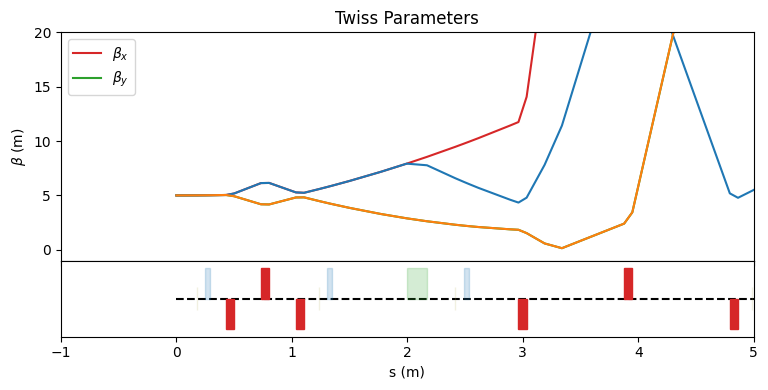

In [4]:
def convert_row_to_element(row) -> cheetah.Element:
    """Takes a row from the MADX output file and converts it into a Cheetah element."""
    sanitized_name = row.NAME.replace(".", "_").replace("$", "_")

    if row.KEYWORD == "MARKER":
        assert row.L == 0.0
        return cheetah.Marker(name=sanitized_name)
    elif row.KEYWORD == "DRIFT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "MONITOR":
        assert row.L == 0.0
        assert sanitized_name.startswith("BPM")
        return cheetah.BPM(name=sanitized_name)
    elif row.KEYWORD == "KICKER":
        # TODO: Horizontal or vertical?
        return cheetah.HorizontalCorrector(
            name=sanitized_name, length=torch.as_tensor(row.L)
        )
    elif row.KEYWORD == "QUADRUPOLE":
        return cheetah.Quadrupole(
            name=sanitized_name,
            length=torch.as_tensor(row.L),
            # k1=torch.as_tensor(row.K1L),
            k1=torch.as_tensor(row.K1L / row.L),  # TODO: Correct?
        )
    elif row.KEYWORD == "INSTRUMENT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "RBEND":
        return cheetah.RBend(name=sanitized_name, length=torch.as_tensor(row.L))
    else:
        raise NotImplementedError(f"Unknown element type: {row.KEYWORD}")


segment = cheetah.Segment(
    elements=[convert_row_to_element(row) for row in df.itertuples()]
)

incoming_beam = cheetah.ParameterBeam.from_twiss(
    energy=torch.as_tensor(0.019006870) * 1e12,  # TODO: TeV -> eV ?
    beta_x=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETX"].values[0]),
    beta_y=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETY"].values[0]),
    alpha_x=torch.tensor(0.0),
    alpha_y=torch.tensor(0.0),
    emittance_x=torch.as_tensor(0.000000269),  # TODO: Unit?
    emittance_y=torch.as_tensor(0.000000269),  # TODO: Unit?
)

segment.plot_twiss_over_lattice(beam=incoming_beam)

plt.gcf().axes[0].plot(df["S"], df["BETX"], label="beta x")
plt.gcf().axes[0].plot(df["S"], df["BETY"], label="beta y")
plt.gcf().axes[0].set_ylim(-1, 20)
plt.gcf().axes[0].set_xlim(-1, 5)

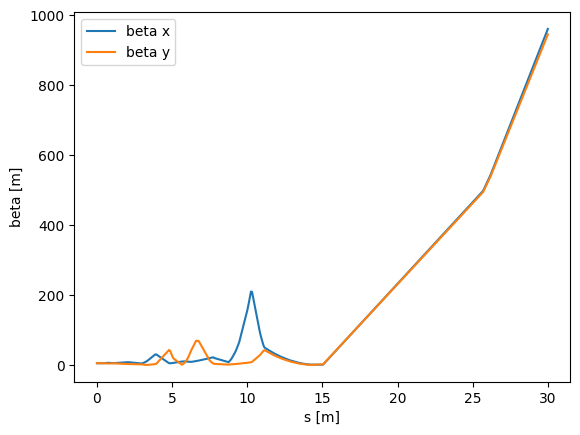

In [5]:
plt.plot(df["S"], df["BETX"], label="beta x")
plt.plot(df["S"], df["BETY"], label="beta y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

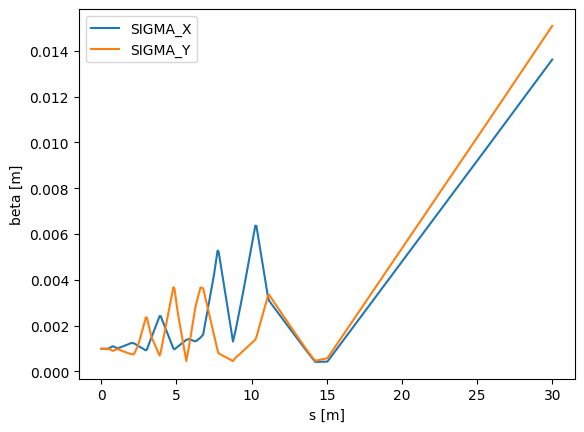

In [6]:
plt.plot(df["S"], df["SIGMA_X"], label="SIGMA_X")
plt.plot(df["S"], df["SIGMA_Y"], label="SIGMA_Y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

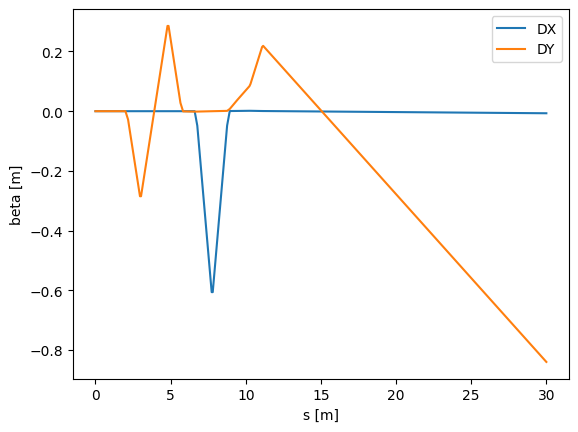

In [7]:
plt.plot(df["S"], df["DX"], label="DX")
plt.plot(df["S"], df["DY"], label="DY")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

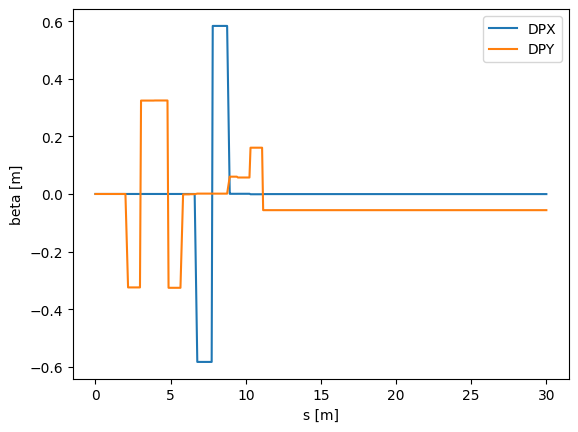

In [8]:
plt.plot(df["S"], df["DPX"], label="DPX")
plt.plot(df["S"], df["DPY"], label="DPY")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

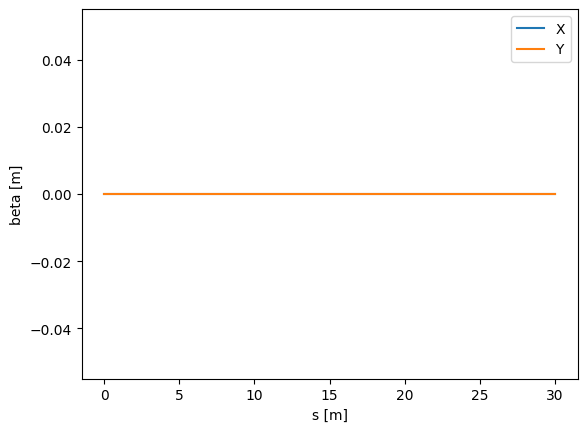

In [9]:
plt.plot(df["S"], df["X"], label="X")
plt.plot(df["S"], df["Y"], label="Y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

In [10]:
segment

Segment(elements=ModuleList(
  (0): Marker(name='TT43_START', device='cpu')
  (1): Marker(name='BEGI_1000', device='cpu')
  (2): Drift(length=tensor(0.1792), name='DRIFT_0', device='cpu')
  (3): BPM(name='BPM_430028', device='cpu')
  (4): Drift(length=tensor(0.0694), name='DRIFT_1', device='cpu')
  (5): HorizontalCorrector(length=tensor(0.0406), angle=tensor(0.), name='MCAWA_430029', device='cpu')
  (6): Drift(length=tensor(0.1410), name='DRIFT_2', device='cpu')
  (7): Quadrupole(length=tensor(0.0708), k1=tensor(-5.0858), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='MQAWD_430031', device="'cpu'")
  (8): Drift(length=tensor(0.2317), name='DRIFT_3', device='cpu')
  (9): Quadrupole(length=tensor(0.0708), k1=tensor(9.5040), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='MQAWF_430034', device="'cpu'")
  (10): Drift(length=tensor(0.2317), name='DRIFT_3', device='cpu')
  (11): Quadrupole(length=tensor(0.0708), k1=tensor(-8.2401), misalignment=tensor([0., 0.]), tilt=tensor(0.),

In [11]:
df[df["DPX"] > 0.0]

,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
56,MQAWF.430311,QUADRUPOLE,7.803610,0.070800,0.005231,0.000781,19.955098,3.161741,-0.606158,0.583355,...,0.001147,34.008555,4.909302,0.0,0.0,1.902521,0.153196,1.101540,0.0,0.0
57,DRIFT_22,DRIFT,8.760221,0.956610,0.001299,0.000447,7.973745,1.034219,-0.048115,0.583355,...,0.001147,-21.483751,-2.685279,0.0,0.0,0.000000,0.641115,1.512821,0.0,0.0
58,MBAWH.412343,RBEND,8.935721,0.175500,0.001795,0.000602,16.694156,1.856662,0.000536,0.000582,...,0.060061,-30.891176,-1.410422,0.0,0.0,0.000000,0.643409,1.533024,0.0,0.0
59,DRIFT_23,DRIFT,8.937971,0.002250,0.001802,0.000603,16.833456,1.863017,0.000537,0.000582,...,0.060061,-31.019925,-1.414045,0.0,0.0,0.000000,0.643430,1.533216,0.0,0.0
60,PLUTO,MARKER,8.937971,0.000000,0.001802,0.000603,16.833456,1.863017,0.000537,0.000582,...,0.060061,-31.019925,-1.414045,0.0,0.0,0.000000,0.643430,1.533216,0.0,0.0
61,DRIFT_24,DRIFT,9.165771,0.227800,0.002559,0.000727,33.935519,2.590805,0.000670,0.000582,...,0.060061,-44.054984,-1.780811,0.0,0.0,0.000000,0.644947,1.549748,0.0,0.0
62,BPM.412343,MONITOR,9.165771,0.000000,0.002559,0.000727,33.935519,2.590805,0.000670,0.000582,...,0.060061,-44.054984,-1.780811,0.0,0.0,0.000000,0.644947,1.549748,0.0,0.0
63,DRIFT_25,DRIFT,9.237170,0.071400,0.002796,0.000770,40.518284,2.853313,0.000712,0.000582,...,0.060061,-48.140599,-1.895768,0.0,0.0,0.000000,0.645254,1.553928,0.0,0.0
64,MCAWA.412344,KICKER,9.277771,0.040600,0.002931,0.000794,44.521622,3.009903,0.000735,0.000582,...,0.060061,-50.463793,-1.961135,0.0,0.0,0.000000,0.645406,1.556133,0.0,0.0
65,DRIFT_26,DRIFT,9.406271,0.128500,0.003358,0.000875,58.435673,3.540500,0.000810,0.000582,...,0.060061,-57.816757,-2.168025,0.0,0.0,0.000000,0.645807,1.562400,0.0,0.0
